In [171]:
#Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import correlation
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

## Understanding each datas

In [145]:
#Links data
links_df = pd.read_csv('links.csv')
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [146]:
#Movies data
movies_df = pd.read_csv('movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [147]:
#Ratings data
ratings_df = pd.read_csv('ratings.csv')
ratings_df = ratings_df.rename(columns={'userId': 'rating_user_id'})
ratings_df.head()

,rating_user_id,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [148]:
#Tags data
tags_df = pd.read_csv('tags.csv')
tags_df = tags_df.rename(columns={'userId': 'tag_user_id'})
tags_df.head()

,tag_user_id,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Merging the dataframes

In [149]:
# Merging DataFrames
merged_df = pd.merge(links_df, movies_df, on='movieId', how='inner')
merged_df = pd.merge(merged_df, ratings_df.drop(columns=['timestamp']), on='movieId', how='left')
final_df = pd.merge(merged_df, tags_df.drop(columns=['timestamp']), on='movieId', how='left')

final_df.head()



,movieId,imdbId,tmdbId,title,genres,rating_user_id,rating,tag_user_id,tag
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,336.0,pixar
1,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,474.0,pixar
2,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,567.0,fun
3,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,336.0,pixar
4,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,474.0,pixar


In [150]:
final_df.shape

(285783, 9)

## Checking for missing value

In [151]:
final_df.isna().sum()

movieId               0
imdbId                0
tmdbId               13
title                 0
genres                0
rating_user_id       21
rating               21
tag_user_id       52549
tag               52549
dtype: int64

Since Tag column has very high missing value and for rating user id and rating we are planning to remove the rows since the value is less and for tmdbid we are planning to replace null value with 0

## Handling the missing value

In [152]:
# 1. Drop 'tag' column due to high missing value
final_df = final_df.drop(columns=['tag'], errors='ignore')

# 2. Drop rows with missing values in 'rating_user_id' or 'rating'
final_df = final_df.dropna(subset=['rating_user_id', 'rating'])

# 3. Replace missing values in 'tmdbId' with 0
final_df['tmdbId'] = final_df['tmdbId'].fillna(0)

# Remove duplicates (optional, if needed)
final_df = final_df.drop_duplicates()

In [153]:
final_df.head()

,movieId,imdbId,tmdbId,title,genres,rating_user_id,rating,tag_user_id
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,336.0
1,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,474.0
2,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,567.0
3,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,336.0
4,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,474.0


In [154]:
final_df.shape

(122726, 8)

## Exploratory Data Analysis

### Understanding Rating Distribution

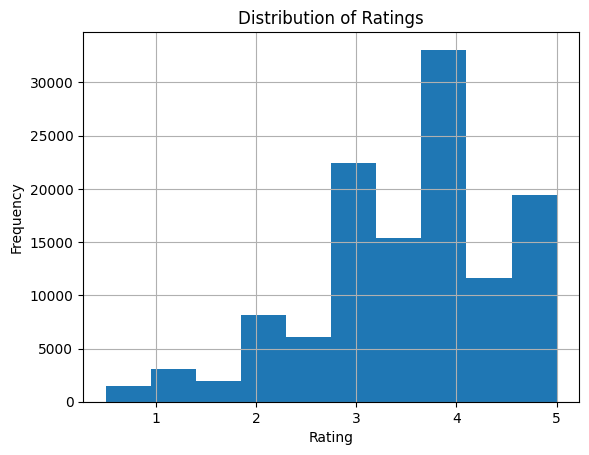

count    122726.000000
mean          3.595061
std           1.040677
min           0.500000
25%           3.000000
50%           4.000000
75%           4.500000
max           5.000000
Name: rating, dtype: float64


In [155]:
import matplotlib.pyplot as plt

# Plot rating distribution
final_df['rating'].hist(bins=10)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Summary statistics
print(final_df['rating'].describe())

### Analyzing User Activity

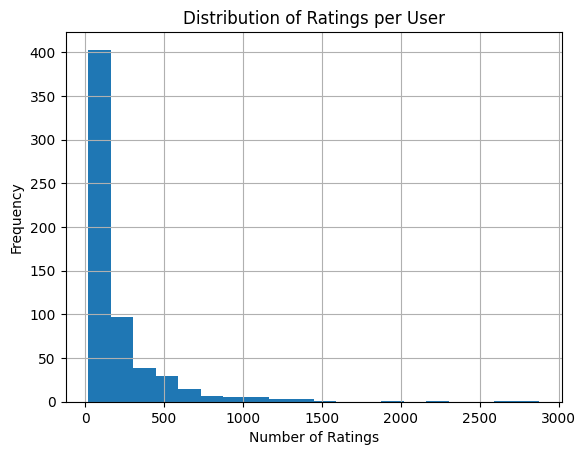

rating_user_id
414.0    2875
599.0    2644
474.0    2278
448.0    1985
274.0    1500
Name: rating, dtype: int64


In [156]:
user_activity = final_df.groupby('rating_user_id')['rating'].count()
user_activity.hist(bins=20)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Top 5 most active users
print(user_activity.sort_values(ascending=False).head())

The histogram shows the distribution of ratings per user, revealing the frequency of users based on how many ratings they provided. The top 5 most active users indicate that a small number of users are highly engaged, while many users have rated fewer movies, highlighting potential data sparsity in the recommendation system.

###  Analyze Movie Popularity

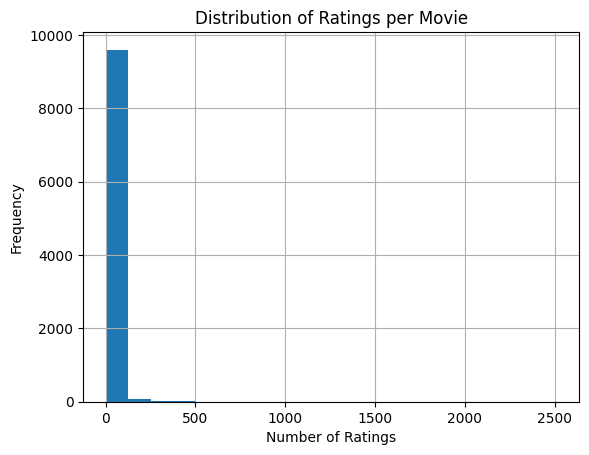

movieId
260     2510
296     1228
356      987
527      880
2959     872
Name: rating, dtype: int64


In [157]:
movie_popularity = final_df.groupby('movieId')['rating'].count()
movie_popularity.hist(bins=20)
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Top 5 most-rated movies
print(movie_popularity.sort_values(ascending=False).head())


The histogram of ratings per movie shows how frequently movies are rated. The plot is skewed, indicates that most movies have few ratings, while a few movies are highly rated.

Inference:

There are likely a few popular movies with a large number of ratings, while most movies receive only a few ratings.
The top 5 most-rated movies are likely the most popular in the dataset.

### Examine Genre Preferences

In [158]:

# Step 1: Split genres into individual categories
genres = final_df['genres'].str.split('|', expand=True).stack()

# Step 2: Count occurrences of each genre
genre_counts = genres.value_counts()

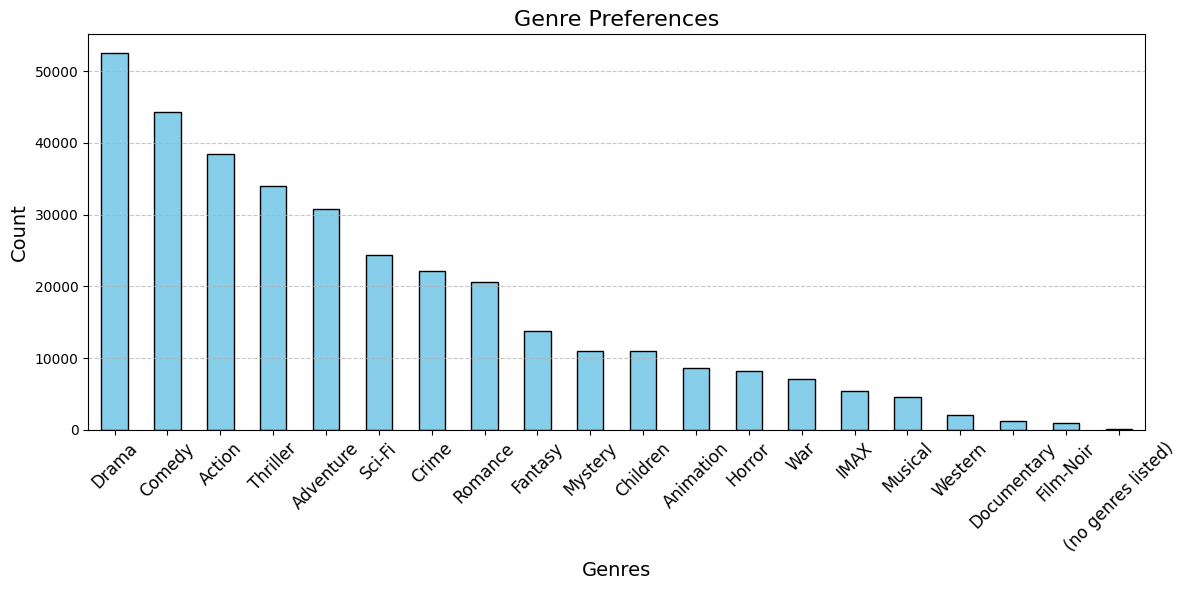

In [159]:
#Plotting the distribution
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Genre Preferences', fontsize=16)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The bar plot shows the distribution of movie genres in the dataset. It reveals the most popular genres based on frequency, helping identify which genres are preferred by users.

## KNN

### Unweighted and Weighted

In [160]:
# KNN prediction function
def knn_predict_for_user_unweighted(movie_id, target_user_id, k, df):
    # Filter for the specific movie
    movie_data = df[df["movieId"] == movie_id]
    
    # Extract unique users and their ratings
    users = movie_data[["rating_user_id", "rating"]].drop_duplicates().reset_index(drop=True)
    
    # Calculate distances from the target user to all other users
    distances = []
    for _, row in users.iterrows():
        if row["rating_user_id"] != target_user_id:  # Exclude the target user
            dist = euclidean([target_user_id], [row["rating_user_id"]])
            distances.append((row["rating_user_id"], row["rating"], dist))
    
    # Sort by distance
    distances = sorted(distances, key=lambda x: x[2])
    
    # Handle ties at the kth neighbor
    neighbors = []
    for i, neighbor in enumerate(distances):
        if i < k or (i >= k and neighbor[2] == distances[k - 1][2]):
            if not pd.isna(neighbor[1]):  # Only include valid ratings
                neighbors.append(neighbor)
        else:
            break
    
    # Predict the rating by averaging the ratings of the neighbors
    if neighbors:
        predicted_rating = np.mean([neighbor[1] for neighbor in neighbors])
    else:
        # Fallback: Use global mean if no neighbors are valid
        predicted_rating = df["rating"].mean()
    
    return predicted_rating

In [ ]:
def knn_weighted_predict_for_user(movie_id, target_user_id, k, df):

    # Filter for the specific movie
    movie_data = df[df["movieId"] == movie_id]
    
    # Extract unique users and their ratings
    users = movie_data[["rating_user_id", "rating"]].drop_duplicates().reset_index(drop=True)
    
    # Calculate distances from the target user to all other users
    distances = []
    for _, row in users.iterrows():
        if row["rating_user_id"] != target_user_id:  # Exclude the target user
            dist = euclidean([target_user_id], [row["rating_user_id"]])
            distances.append((row["rating_user_id"], row["rating"], dist))
    
    # Sort by distance
    distances = sorted(distances, key=lambda x: x[2])
    
    # Handle ties at the kth neighbor
    neighbors = []
    for i, neighbor in enumerate(distances):
        if i < k or (i >= k and neighbor[2] == distances[k - 1][2]):
            if not pd.isna(neighbor[1]):  # Only include valid ratings
                neighbors.append(neighbor)
        else:
            break
    
    # Predict the rating using weighted average
    if neighbors:
        # Calculate weights as 1 / distance (add a small epsilon to avoid division by zero)
        epsilon = 1e-9
        weighted_sum = sum((1 / (neighbor[2] + epsilon)) * neighbor[1] for neighbor in neighbors)
        total_weight = sum(1 / (neighbor[2] + epsilon) for neighbor in neighbors)
        predicted_rating = weighted_sum / total_weight
    else:
        # Fallback: Use global mean if no neighbors are valid
        predicted_rating = df["rating"].mean()
    
    return predicted_rating

In [161]:
# Function to predict ratings for all users for a single movie
def predict_ratings_for_movie(movie_id, k, df,KNN_method):
    users = df[df["movieId"] == movie_id]["rating_user_id"].unique()
    predictions = []
    for user_id in users:
        predicted_rating = KNN_method(movie_id, user_id, k, df)
        actual_rating = df[(df["movieId"] == movie_id) & (df["rating_user_id"] == user_id)]["rating"].values[0]
        predictions.append({"movie_id": movie_id, "user_id": user_id, "predicted": predicted_rating, "actual": actual_rating})
    return pd.DataFrame(predictions)


In [33]:
# Function to predict ratings for all movies in the dataset
def predict_ratings_for_all_movies(k, df,KNN_method):
    unique_movies = df["movieId"].unique()
    all_predictions = []
    for movie_id in unique_movies:
        movie_predictions = predict_ratings_for_movie(movie_id, k, df,KNN_method)
        all_predictions.append(movie_predictions)
    return pd.concat(all_predictions, ignore_index=True)


In [162]:

# Calculate RMSE for all movies
def calculate_overall_rmse(predictions_df):
    # Drop rows where 'predicted' or 'actual' is NaN
    valid_predictions = predictions_df.dropna(subset=["predicted", "actual"])
    
    # If no valid rows remain, return NaN
    if valid_predictions.empty:
        print("No valid rows for RMSE calculation. Returning NaN.")
        return np.nan
    
    # Extract valid actual and predicted values
    actual = valid_predictions["actual"]
    predicted = valid_predictions["predicted"]
    
    # Calculate and return RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return rmse

In [ ]:

vals = [3,5,10]
rmse_knn_unweighht=[]
for k in vals:

    # Predict ratings for all users across all movies
    all_predictions_df_weighted = predict_ratings_for_all_movies(k, final_df,knn_predict_for_user_unweighted)
    overall_rmse = calculate_overall_rmse(all_predictions_df_weighted)
    rmse_knn_unweighht.append(overall_rmse)
    csv_name = 'KNN_UNWEIGHTED'+f'{k}'+'.CSV'
    all_predictions_df_weighted.to_csv(csv_name,index=False)
    print("\nOverall Root Mean Squared Error (RMSE):", overall_rmse)    


Overall Root Mean Squared Error (RMSE): 1.0740761486412393

Overall Root Mean Squared Error (RMSE): 1.0268727889725122

Overall Root Mean Squared Error (RMSE): 0.9946036968752594


In [164]:
vals = [3,5,10]
rmse_knn_weighht=[]
for k in vals:

    # Predict ratings for all users across all movies
    all_predictions_df_weighted = predict_ratings_for_all_movies(k, final_df,knn_weighted_predict_for_user)
    overall_rmse = calculate_overall_rmse(all_predictions_df_weighted)
    rmse_knn_unweighht.append(overall_rmse)
    csv_name = 'KNN_WEIGHTED_'+f'{k}'+'.CSV'
    all_predictions_df_weighted.to_csv(csv_name,index=False)
    print("\nOverall Root Mean Squared Error (RMSE):", overall_rmse) 


Overall Root Mean Squared Error (RMSE): 1.1175451436470567

Overall Root Mean Squared Error (RMSE): 1.0801135537844357

Overall Root Mean Squared Error (RMSE): 1.0514892565469909


## Collaborative Filtering

### Sarwar Method

In [ ]:
# Step 1: Handle duplicate entries
final_df = final_df.groupby(['rating_user_id', 'movieId'], as_index=False).agg({'rating': 'mean'})

# Step 2: Train-test split (60-40)
train, test = train_test_split(final_df, test_size=0.2, random_state=42)

# Step 3: Create utility matrix for training data
train_utility_matrix = train.pivot(index='rating_user_id', columns='movieId', values='rating')

# Step 4: Zero-center the utility matrix
movie_means = train_utility_matrix.mean(axis=0)
zero_centered_matrix = train_utility_matrix.subtract(movie_means, axis=1)

# Fill NaN values with 0 for similarity computation
zero_centered_matrix = zero_centered_matrix.fillna(0)

# Step 5: Compute similarity matrix using Pearson correlation
similarity_matrix = np.corrcoef(zero_centered_matrix.T)

# Get movie indices for lookup
movie_index_mapping = {movie: idx for idx, movie in enumerate(zero_centered_matrix.columns)}
index_movie_mapping = {idx: movie for movie, idx in movie_index_mapping.items()}


c:\Users\sridh\OneDrive\Desktop\CS 504\Project\ml-latest-small\cs_virtual\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\sridh\OneDrive\Desktop\CS 504\Project\ml-latest-small\cs_virtual\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [207]:
def predict_rating(user_id, movie_id):
    # Check if movie and user exist in the training data
    if user_id not in zero_centered_matrix.index or movie_id not in movie_index_mapping:
        return np.nan  # Return NaN if user or movie not found
    
    # Get the movie index
    movie_idx = movie_index_mapping[movie_id]
    
    # Get the similarity scores for the target movie
    movie_similarities = similarity_matrix[movie_idx]
    
    # Get the ratings given by the user
    user_ratings = zero_centered_matrix.loc[user_id]
    
    # Find the indices of movies rated by the user
    rated_indices = user_ratings[user_ratings != 0].index.map(movie_index_mapping)
    
    # Calculate weighted average of ratings
    numerator = 0
    denominator = 0
    for idx in rated_indices:
        if not np.isnan(movie_similarities[idx]):  # Skip NaN similarities
            numerator += movie_similarities[idx] * user_ratings.iloc[movie_index_mapping[index_movie_mapping[idx]]]
            denominator += abs(movie_similarities[idx])
    
    # If no valid neighbors, return global mean
    if denominator == 0:
        return movie_means[movie_id]
    
    # Return the predicted rating
    return numerator / denominator + movie_means[movie_id]

In [208]:
# Predict ratings for all rows in the test set
test['predicted'] = test.apply(lambda row: predict_rating(row['rating_user_id'], row['movieId']), axis=1)


In [209]:
test.to_csv('colaborative_filter_sarwar_80-20.csv')

In [210]:
test_df = test.fillna(0)

In [ ]:
# RMSE: 1.1918304587912651
# RMSE: 1.1537869461877532
# RMSE: 1.1306925246791182

In [211]:
rmse = np.sqrt(mean_squared_error(test_df['rating'], test_df['predicted']))
print("RMSE:", rmse)

RMSE: 1.1306925246791182
